## パーセプトロン

AND,NAND,OR,XORゲートの実装

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5])
    b = -0.7
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1

In [5]:
def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-0.5, -0.5]) # 重みとバイアスだけがANDと違う！
    b = 0.7
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1

def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5]) # 重みとバイアスだけがANDと違う！
    b = -0.2
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1


In [6]:
def XOR(x1, x2):
    s1 = NAND(x1, x2)
    s2 = OR(x1, x2)
    y = AND(s1, s2)
    return y

# ニューラルネットワーク

## 活性化関数

- ステップ関数

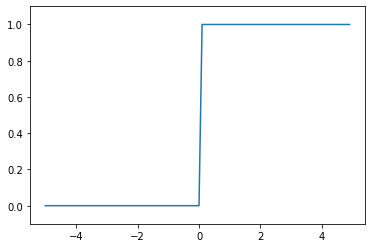

In [7]:
def step_function(x):
    return np.array(x > 0, dtype=int)

x = np.arange(-5.0, 5.0, 0.1)
y = step_function(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1) # y軸の範囲を指定
plt.show()

- シグモイド関数

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

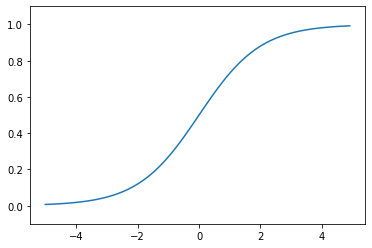

In [9]:
x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1) # y軸の範囲を指定
plt.show()

- ReLU関数

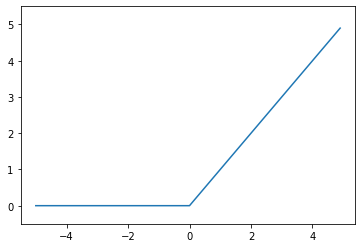

In [17]:
def relu(x):
    return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)
plt.plot(x, y)
plt.ylim(-0.5, 5.5) # y軸の範囲を指定
plt.show()

- ソフトマックス関数

In [18]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # オーバーフロー対策
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

## MNISTデータセット

In [35]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import pickle
def get_data():
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    x_train, x_test, y_train, y_test = train_test_split(X / 255, # ピクセル値が 0 - 1 になるようにする
                                                        y.astype('int64'), # 正解データを数値にする
                                                        stratify = y,
                                                        random_state=0)
    return x_test, y_test

def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)

    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

In [25]:
x, t = get_data()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y) # 最も確率の高い要素のインデックスを取得
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9378285714285715


In [26]:
x, t = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']

In [27]:
x.shape

(17500, 784)

In [28]:
x[0].shape

(784,)

In [29]:
W1.shape

(784, 50)

In [30]:
W2.shape

(50, 100)

In [31]:
W3.shape

(100, 10)

In [37]:
start = time.time()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y) # 最も確率の高い要素のインデックスを取得
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))
print("Time:"+str(time.time()-start))

Accuracy:0.9378285714285715
Time:3.6013569831848145


In [38]:
start = time.time()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))
print("Time:"+str(time.time()-start))

Accuracy:0.9378285714285715
Time:0.3302583694458008


# ニューラルネットワークの学習

重みパラメータの学習

データから重みを決定する。

機械学習の場合、人が考えた特徴量をもとに機械学習を行うが、
ニューラルネットワークの場合、データからそのまま学習を行う。

すべての問題を同じ流れで解くことができるのがメリット

## 損失関数
- 2乗和誤差

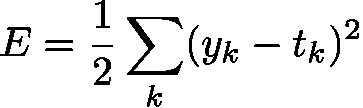

- 交差エントロピー誤差
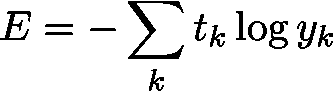

In [42]:
x_train = x
t_train = t

In [43]:
print(x_train.shape) # (60000, 784)
print(t_train.shape) # (60000, 10)

(17500, 784)
(17500,)


In [44]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [45]:
np.random.choice(60000, 10)

array([28236, 31010, 20502, 57043, 57408, 39422, 34768, 41857, 13099,
       15241])

In [46]:
# 交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [47]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [51]:
def function_2(x):
    return x[0]**2 + x[1]**2
    # または return np.sum(x**2)

In [76]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列を生成

    for idx in range(x.shape[0]):
        tmp_val = x[idx]
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元に戻す

    return grad

In [53]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [55]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [54]:
numerical_gradient(function_2, np.array([-1.0, 0.0]))

array([-2.,  0.])

### 勾配法

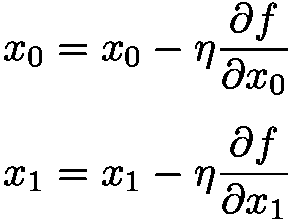



In [57]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x  = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x

In [59]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [65]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.01, step_num=100)

array([-0.39785867,  0.53047822])

lrがハイパーパラメータになる。大きくても小さくてもダメ。

In [66]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化
    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [79]:
net = simpleNet()
print(net.W)

[[ 0.73142145  1.1551937   0.45871528]
 [-1.45370276  1.57648601 -1.75883674]]


In [80]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
np.argmax(p)
t = np.array([0, 0, 1])
net.loss(x, t)

[-0.86947962  2.11195363 -1.3077239 ]


6.203294117192355

In [81]:
def f(W):
    return net.loss(x, t)

In [82]:
dW = numerical_gradient(f, net.W)
print(dW)

[[-4.4408921e-12 -4.4408921e-12 -4.4408921e-12]
 [ 4.4408921e-12  4.4408921e-12  4.4408921e-12]]


In [99]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [107]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [109]:
from two_layer_net import TwoLayerNet
iters_num = 100
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    #grad = network.gradient(x_batch, t_batch) # 高速版!

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % 10 == 0:
        print(str(i) + ' : ' + str(loss))

0 : 2.2946032474834275


KeyboardInterrupt: 